In [1]:
!pip install -U langgraph "langchain[openai]" langchain_community

In [2]:
from dotenv import load_dotenv
from langchain_community.utilities import GoogleSerperAPIWrapper
import requests
import os
from typing import TypedDict,Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START,END
from langchain.agents import Tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
import gradio as gr

In [3]:
load_dotenv(override=True)

True

In [4]:
serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France")

'Paris is the capital and largest city of France, with an estimated city center population of 2,048,472, and a metropolitan population of 13,171,056 as of ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. It is home to ...

In [5]:
# Langchain wrapper class to convert functions into Tools
tool_search = Tool(
    name="search",
    func=serper.run,
    description="Useful for when you need more information from an online search"
)

In [6]:
tool_search.invoke("What is the capital of France")

'Paris is the capital and largest city of France, with an estimated city center population of 2,048,472, and a metropolitan population of 13,171,056 as of ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. It is home to ...

In [7]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text:str):
    """Send a push notification to the user"""
    requests.post(pushover_url,data={"token":pushover_token,"user":pushover_user,"message":text})

In [8]:
tool_push = Tool(
    name="send_push_notification",
    func=push,
    description="Useful for when you want to send a push notification"
)
tool_push.invoke("Hello")

In [9]:
tools =[tool_search,tool_push]

In [10]:
# Step 1 :Define the state object
class State(TypedDict):
    messages:Annotated[list,add_messages]


In [11]:
# Step 2: Start the GraphBuilder with this State class
graph_builder = StateGraph(State)

In [12]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [13]:
# Step 3: Create a node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [14]:
# Step 4 : Create Edges
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

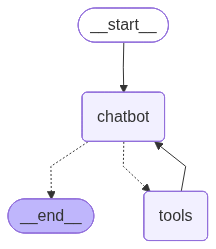

In [15]:
# Step 5 : Compile the graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
def chat(user_input:str, history):
    result = graph.invoke({"messages":[{"role":"user","content":user_input}]})
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


### Adding memory

In [17]:
from langgraph.checkpoint.memory import MemorySaver
memory =MemorySaver()

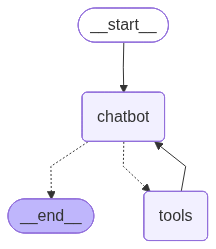

In [18]:
# Step 1:
class State(TypedDict):
    messages:Annotated[list,add_messages]

# Step 2:
graph_builder = StateGraph(State)

#Step 3:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    print(state)
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools=tools))

# Step 4:
graph_builder.add_conditional_edges("chatbot",tools_condition,"tools")
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START, "chatbot")

#Step 5:
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))



In [19]:
config = {"configurable":{"thread_id":"1"}}
def chat(user_input:str, history):
    result = graph.invoke({"messages":[{"role":"user","content":user_input}]},config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


In [20]:
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [21]:
list(graph.get_state_history(config))

[]